## Мазанов Артем

# Домашнее задание 2

В данном задании нужно было посчитать simhash у файлов и с помощью него найти неточные дубли. Я воспользовался библиотекой Simhash, чтобы посчитать хэши файлов, при этом файл я разбивал на куски по 4 буквы. У нас есть папка **txt_docs** с текстами. Ниже подсчет хэшей, параллельно запоминаем длины документов:

In [13]:
import re
import os
import sys
from simhash import Simhash


def get_features(s):
    width = 4
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]


doc_lengths = dict()
doc_simhashes = dict()
doc_amount_of_once = dict()

for i, file_name in enumerate(os.listdir('txt_docs')):
    sys.stdout.write("\rProcessing {0}".format(i))
    doc_lengths[file_name] = os.path.getsize('txt_docs/' + file_name)
    with open('txt_docs/' + file_name, 'r') as f:
        doc_simhashes[file_name] = Simhash(get_features(f.read())).value
        doc_amount_of_once[file_name] = bin(doc_simhashes[file_name]).count('1') 

Processing 142903

В **urls.txt** находятся соответствия *url* и *n.html* (с помощью небольших манипуляций это соответствие продляется и на n.txt файлы)

In [159]:
txt_to_url = dict()

with open('urls.txt', 'r') as f:
    lines = f.read().split('\n')
    for line in lines:
        elems = line.split('\t')
        txt_to_url[elems[0][:-5] + '.txt'] = elems[1]

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
import operator
sorted_doc_lengths = sorted(doc_lengths.items(), key=operator.itemgetter(1))

## N = 5

Ниже реализован алгоритм кластеризации файлов. Идея его проста: сначала сортируем документы по возрастанию размера. Проходим по всем документам и ищем ближайшего похожего (разница хешей и размеров небольшая) главного соседа из тех документов, что уже рассмотрели. Если есть такой сосед, то он становится для нас главным. Иначе мы остаемся главным для себя. При этом мы рассматриваем сначала самых близких по длине соседей, и если разница в размере становится больше 20%, то останавливаем поиск.

In [132]:
distance = 5

classes1 = list()
group_sizes1 = dict()
docs_in_classes1 = dict()

size = len(sorted_doc_lengths)
for i, (doc, length) in enumerate(sorted_doc_lengths):
    sys.stdout.write("\rProcessing {0}".format(i))
    min_dist = distance + 1
    closest_doc = doc
    for main_doc in reversed(classes1):
        second_length = doc_lengths[main_doc]
        if length > 1.2 * second_length:
            break
        pair_dist = bin(doc_simhashes[doc]^doc_simhashes[main_doc]).count('1')
        if pair_dist < min_dist:
            min_dist = pair_dist
            closest_doc = main_doc
    if closest_doc == doc:
        classes1.append(closest_doc)
    if docs_in_classes1.get(closest_doc) is None:
        docs_in_classes1[closest_doc] = [doc]
    else:
        docs_in_classes1[closest_doc].append(doc)
    if group_sizes1.get(closest_doc) is None:
        group_sizes1[closest_doc] = 1
    else:
        group_sizes1[closest_doc] += 1

Processing 142903

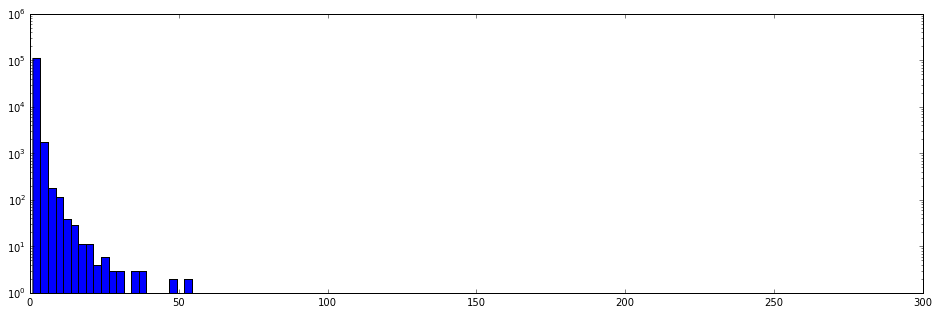

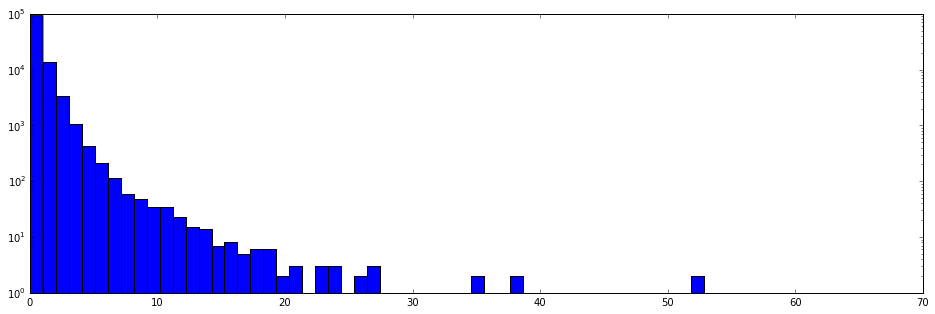

In [133]:
num_bins = 100
plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(group_sizes1.values(), num_bins, facecolor='blue')
plt.yscale('log', nonposy = 'clip')
plt.show()

plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(group_sizes1.values(), 59, facecolor='blue', range = (0, 60))
plt.yscale('log', nonposy = 'clip')
plt.show()

Выведем топ 10 главных для каждого параметра n. Заодно выведем еще по 2 элемента из каждого класса, чтобы убедиться, что они похожи:

In [134]:
sorted_group_sizes1 = sorted(group_sizes1.items(), key=operator.itemgetter(1), reverse = True)

In [160]:
for doc, size in sorted_group_sizes1[:10]:
    print txt_to_url[doc], size
    for elem in docs_in_classes1[doc][1:3]:
        print ' ', txt_to_url[elem]

https://simple.wikipedia.org/wiki/.ki 255
  https://simple.wikipedia.org/wiki/.mn
  https://simple.wikipedia.org/wiki/.ro
https://simple.wikipedia.org/wiki/Pope_Gelasius_I 138
  https://simple.wikipedia.org/wiki/Pope_Mark
  https://simple.wikipedia.org/wiki/Pope_John_XI
https://simple.wikipedia.org/wiki/Eps 113
  https://simple.wikipedia.org/wiki/Eps,_Pas-de-Calais
  https://simple.wikipedia.org/wiki/Oppy
https://simple.wikipedia.org/wiki/Bomy 83
  https://simple.wikipedia.org/wiki/Rety
  https://simple.wikipedia.org/wiki/Vimy
https://simple.wikipedia.org/wiki/Ryes 65
  https://simple.wikipedia.org/wiki/Jort
  https://simple.wikipedia.org/wiki/Glos
https://simple.wikipedia.org/wiki/Bey,_Ain 61
  https://simple.wikipedia.org/wiki/Cize,_Ain
  https://simple.wikipedia.org/wiki/Lent,_Ain
https://simple.wikipedia.org/wiki/Cry,_Yonne 58
  https://simple.wikipedia.org/wiki/Cuy,_Yonne
  https://simple.wikipedia.org/wiki/Dy%C3%A9
https://simple.wikipedia.org/wiki/Brie,_Aisne 52
  https://simple

## N = 10

In [136]:
distance = 10

classes2 = list()
group_sizes2 = dict()
docs_in_classes2 = dict()

for i, (doc, length) in enumerate(sorted_doc_lengths):
    sys.stdout.write("\rProcessing {0}".format(i))
    min_dist = distance + 1
    closest_doc = doc
    for main_doc in reversed(classes2):
        second_length = doc_lengths[main_doc]
        if length > 1.2 * second_length:
            break
        pair_dist = bin(doc_simhashes[doc]^doc_simhashes[main_doc]).count('1')
        if pair_dist < min_dist:
            min_dist = pair_dist
            closest_doc = main_doc
    if closest_doc == doc:
        classes2.append(closest_doc)
    if docs_in_classes2.get(closest_doc) is None:
        docs_in_classes2[closest_doc] = [doc]
    else:
        docs_in_classes2[closest_doc].append(doc)
    if group_sizes2.get(closest_doc) is None:
        group_sizes2[closest_doc] = 1
    else:
        group_sizes2[closest_doc] += 1

Processing 142903

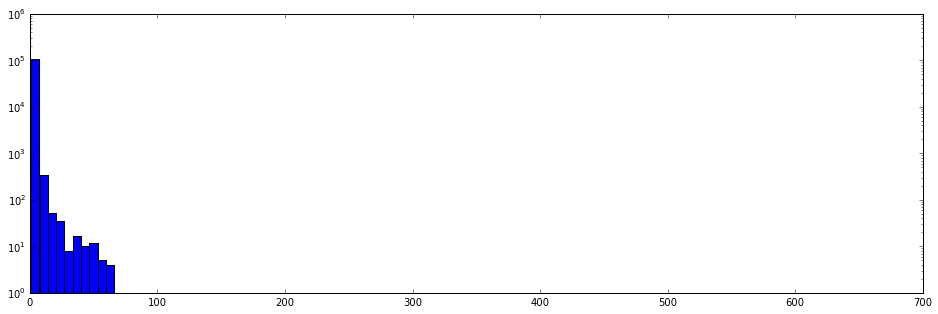

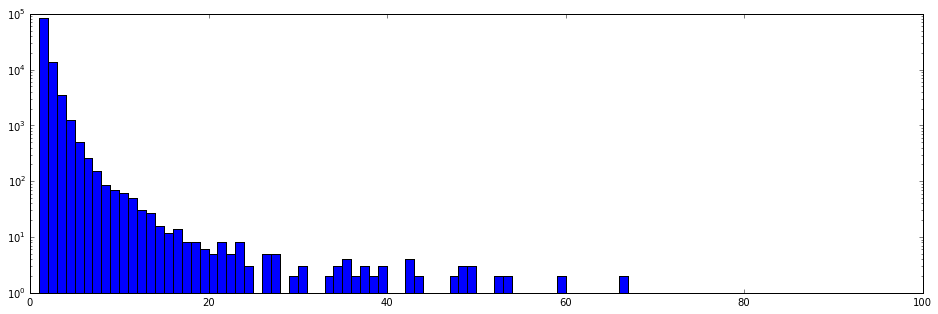

In [150]:
num_bins = 100
plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(group_sizes2.values(), num_bins, facecolor='blue')
plt.yscale('log', nonposy = 'clip')
plt.show()

plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(group_sizes2.values(), num_bins, facecolor='blue', range = (0, 100))
plt.yscale('log', nonposy = 'clip')
plt.show()

In [138]:
sorted_group_sizes2 = sorted(group_sizes2.items(), key=operator.itemgetter(1), reverse = True)

In [161]:
for doc, size in sorted_group_sizes2[:10]:
    print txt_to_url[doc], size
    for elem in docs_in_classes2[doc][1:3]:
        print ' ', txt_to_url[elem]

https://simple.wikipedia.org/wiki/Eps 653
  https://simple.wikipedia.org/wiki/Bihucourt
  https://simple.wikipedia.org/wiki/Eps,_Pas-de-Calais
https://simple.wikipedia.org/wiki/Gizy 337
  https://simple.wikipedia.org/wiki/Brie,_Aisne
  https://simple.wikipedia.org/wiki/Lizy
https://simple.wikipedia.org/wiki/Bey,_Ain 309
  https://simple.wikipedia.org/wiki/Boz,_Ain
  https://simple.wikipedia.org/wiki/Cormoz
https://simple.wikipedia.org/wiki/Thaon 264
  https://simple.wikipedia.org/wiki/Mouen
  https://simple.wikipedia.org/wiki/Orbec
https://simple.wikipedia.org/wiki/.ki 255
  https://simple.wikipedia.org/wiki/.mn
  https://simple.wikipedia.org/wiki/.ro
https://simple.wikipedia.org/wiki/Urt 239
  https://simple.wikipedia.org/wiki/Momy
  https://simple.wikipedia.org/wiki/Ance
https://simple.wikipedia.org/wiki/Auros 188
  https://simple.wikipedia.org/wiki/Blaye
  https://simple.wikipedia.org/wiki/Bayas
https://simple.wikipedia.org/wiki/Vix,_Vend%C3%A9e 171
  https://simple.wikipedia.org/wi

## N = 15

In [140]:
distance = 15

classes3 = list()
group_sizes3 = dict()
docs_in_classes3 = dict()
distances = dict()

for i, (doc, length) in enumerate(sorted_doc_lengths):
    sys.stdout.write("\rProcessing {0}".format(i))
    min_dist = distance + 1
    closest_doc = doc
    for main_doc in reversed(classes3):
        second_length = doc_lengths[main_doc]
        if length > 1.2 * second_length:
            break
        pair_dist = bin(doc_simhashes[doc]^doc_simhashes[main_doc]).count('1')
        if distances.get(pair_dist) is None:
            distances[pair_dist] = 1
        else:
            distances[pair_dist] += 1
        if pair_dist < min_dist:
            min_dist = pair_dist
            closest_doc = main_doc
    if closest_doc == doc:
        classes3.append(closest_doc)
    if docs_in_classes3.get(closest_doc) is None:
        docs_in_classes3[closest_doc] = [doc]
    else:
        docs_in_classes3[closest_doc].append(doc)
    if group_sizes3.get(closest_doc) is None:
        group_sizes3[closest_doc] = 1
    else:
        group_sizes3[closest_doc] += 1

Processing 142903

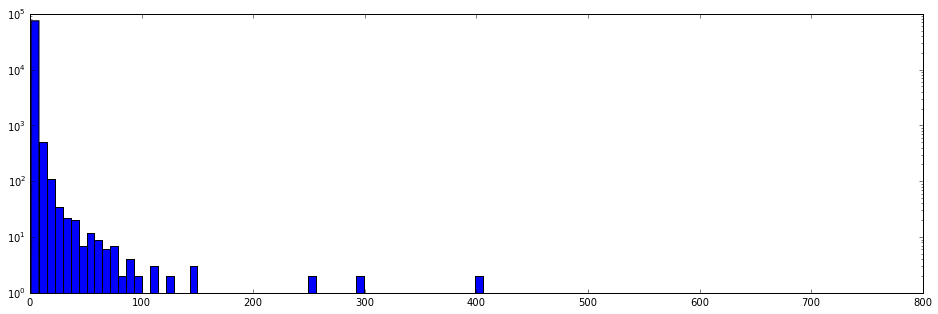

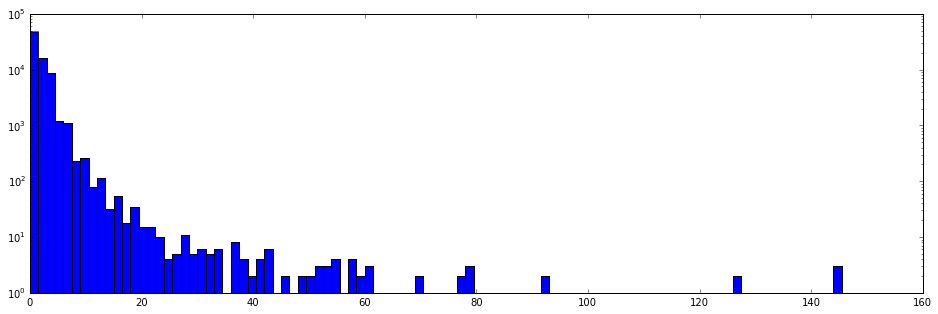

In [152]:
num_bins = 100
plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(group_sizes3.values(), num_bins, facecolor='blue')
plt.yscale('log', nonposy = 'clip')
plt.show()

plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(group_sizes3.values(), num_bins, facecolor='blue', range = (0, 150))
plt.yscale('log', nonposy = 'clip')
plt.show()

In [142]:
sorted_group_sizes3 = sorted(group_sizes3.items(), key=operator.itemgetter(1), reverse = True)

In [162]:
for doc, size in sorted_group_sizes3[:10]:
    print txt_to_url[doc], size
    for elem in docs_in_classes3[doc][1:3]:
        print ' ',txt_to_url[elem]

https://simple.wikipedia.org/wiki/Bihucourt 711
  https://simple.wikipedia.org/wiki/Eps,_Pas-de-Calais
  https://simple.wikipedia.org/wiki/Oppy
https://simple.wikipedia.org/wiki/Coin,_Iowa 450
  https://simple.wikipedia.org/wiki/Olds,_Iowa
  https://simple.wikipedia.org/wiki/Rake,_Iowa
https://simple.wikipedia.org/wiki/Pontru 408
  https://simple.wikipedia.org/wiki/Lislet
  https://simple.wikipedia.org/wiki/Bieuxy
https://simple.wikipedia.org/wiki/Lison 405
  https://simple.wikipedia.org/wiki/Pontvallain
  https://simple.wikipedia.org/wiki/Esson
https://simple.wikipedia.org/wiki/Urt 401
  https://simple.wikipedia.org/wiki/Momy
  https://simple.wikipedia.org/wiki/Ance
https://simple.wikipedia.org/wiki/Vix,_Vend%C3%A9e 358
  https://simple.wikipedia.org/wiki/Spay,_Sarthe
  https://simple.wikipedia.org/wiki/Cr%C3%A9
https://simple.wikipedia.org/wiki/Espiet 299
  https://simple.wikipedia.org/wiki/Talais
  https://simple.wikipedia.org/wiki/Bonzac
https://simple.wikipedia.org/wiki/Boz,_Ain 2

Далее приведена гистограмма распределения расстояний. Из нее видно, что расстояния сконцентрированы в районе 31-32 и распределение близкое к нормальному

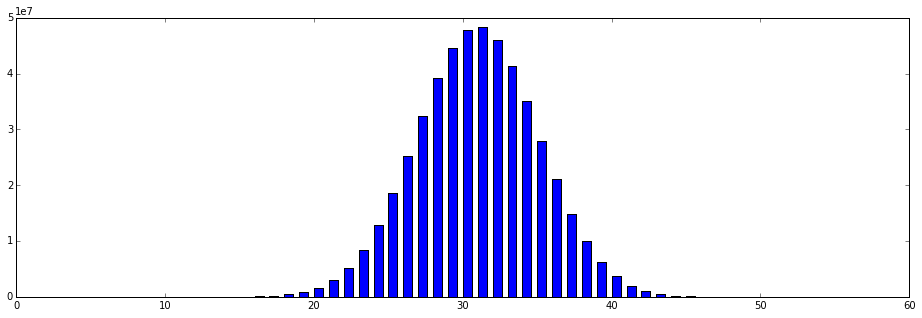

In [144]:
num_bins = 100
plt.figure(figsize = (16,5))
plt.bar(distances.keys(), distances.values(), 0.6, color='b')
plt.show()